In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import holidays

import statsmodels.api as sm
from statsmodels.tsa.seasonal import MSTL, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon

from data_prepro import get_energy_data_today

In [2]:
df_energy = get_energy_data_today(to_date="20231201")
print(df_energy.info())
df_energy.tail(5)

C:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
0 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78168 entries, 2014-12-31 23:00:00+00:00 to 2023-12-01 22:00:00+00:00
Freq: H
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   timestamp_CET  78168 non-null  datetime64[ns, CET]
 1   gesamt         78168 non-null  float64            
dtypes: datetime64[ns, CET](1), float64(1)
memory usage: 1.8 MB
None


,timestamp_CET,gesamt
timestamp_UTC,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75


### Exploratory Analysis

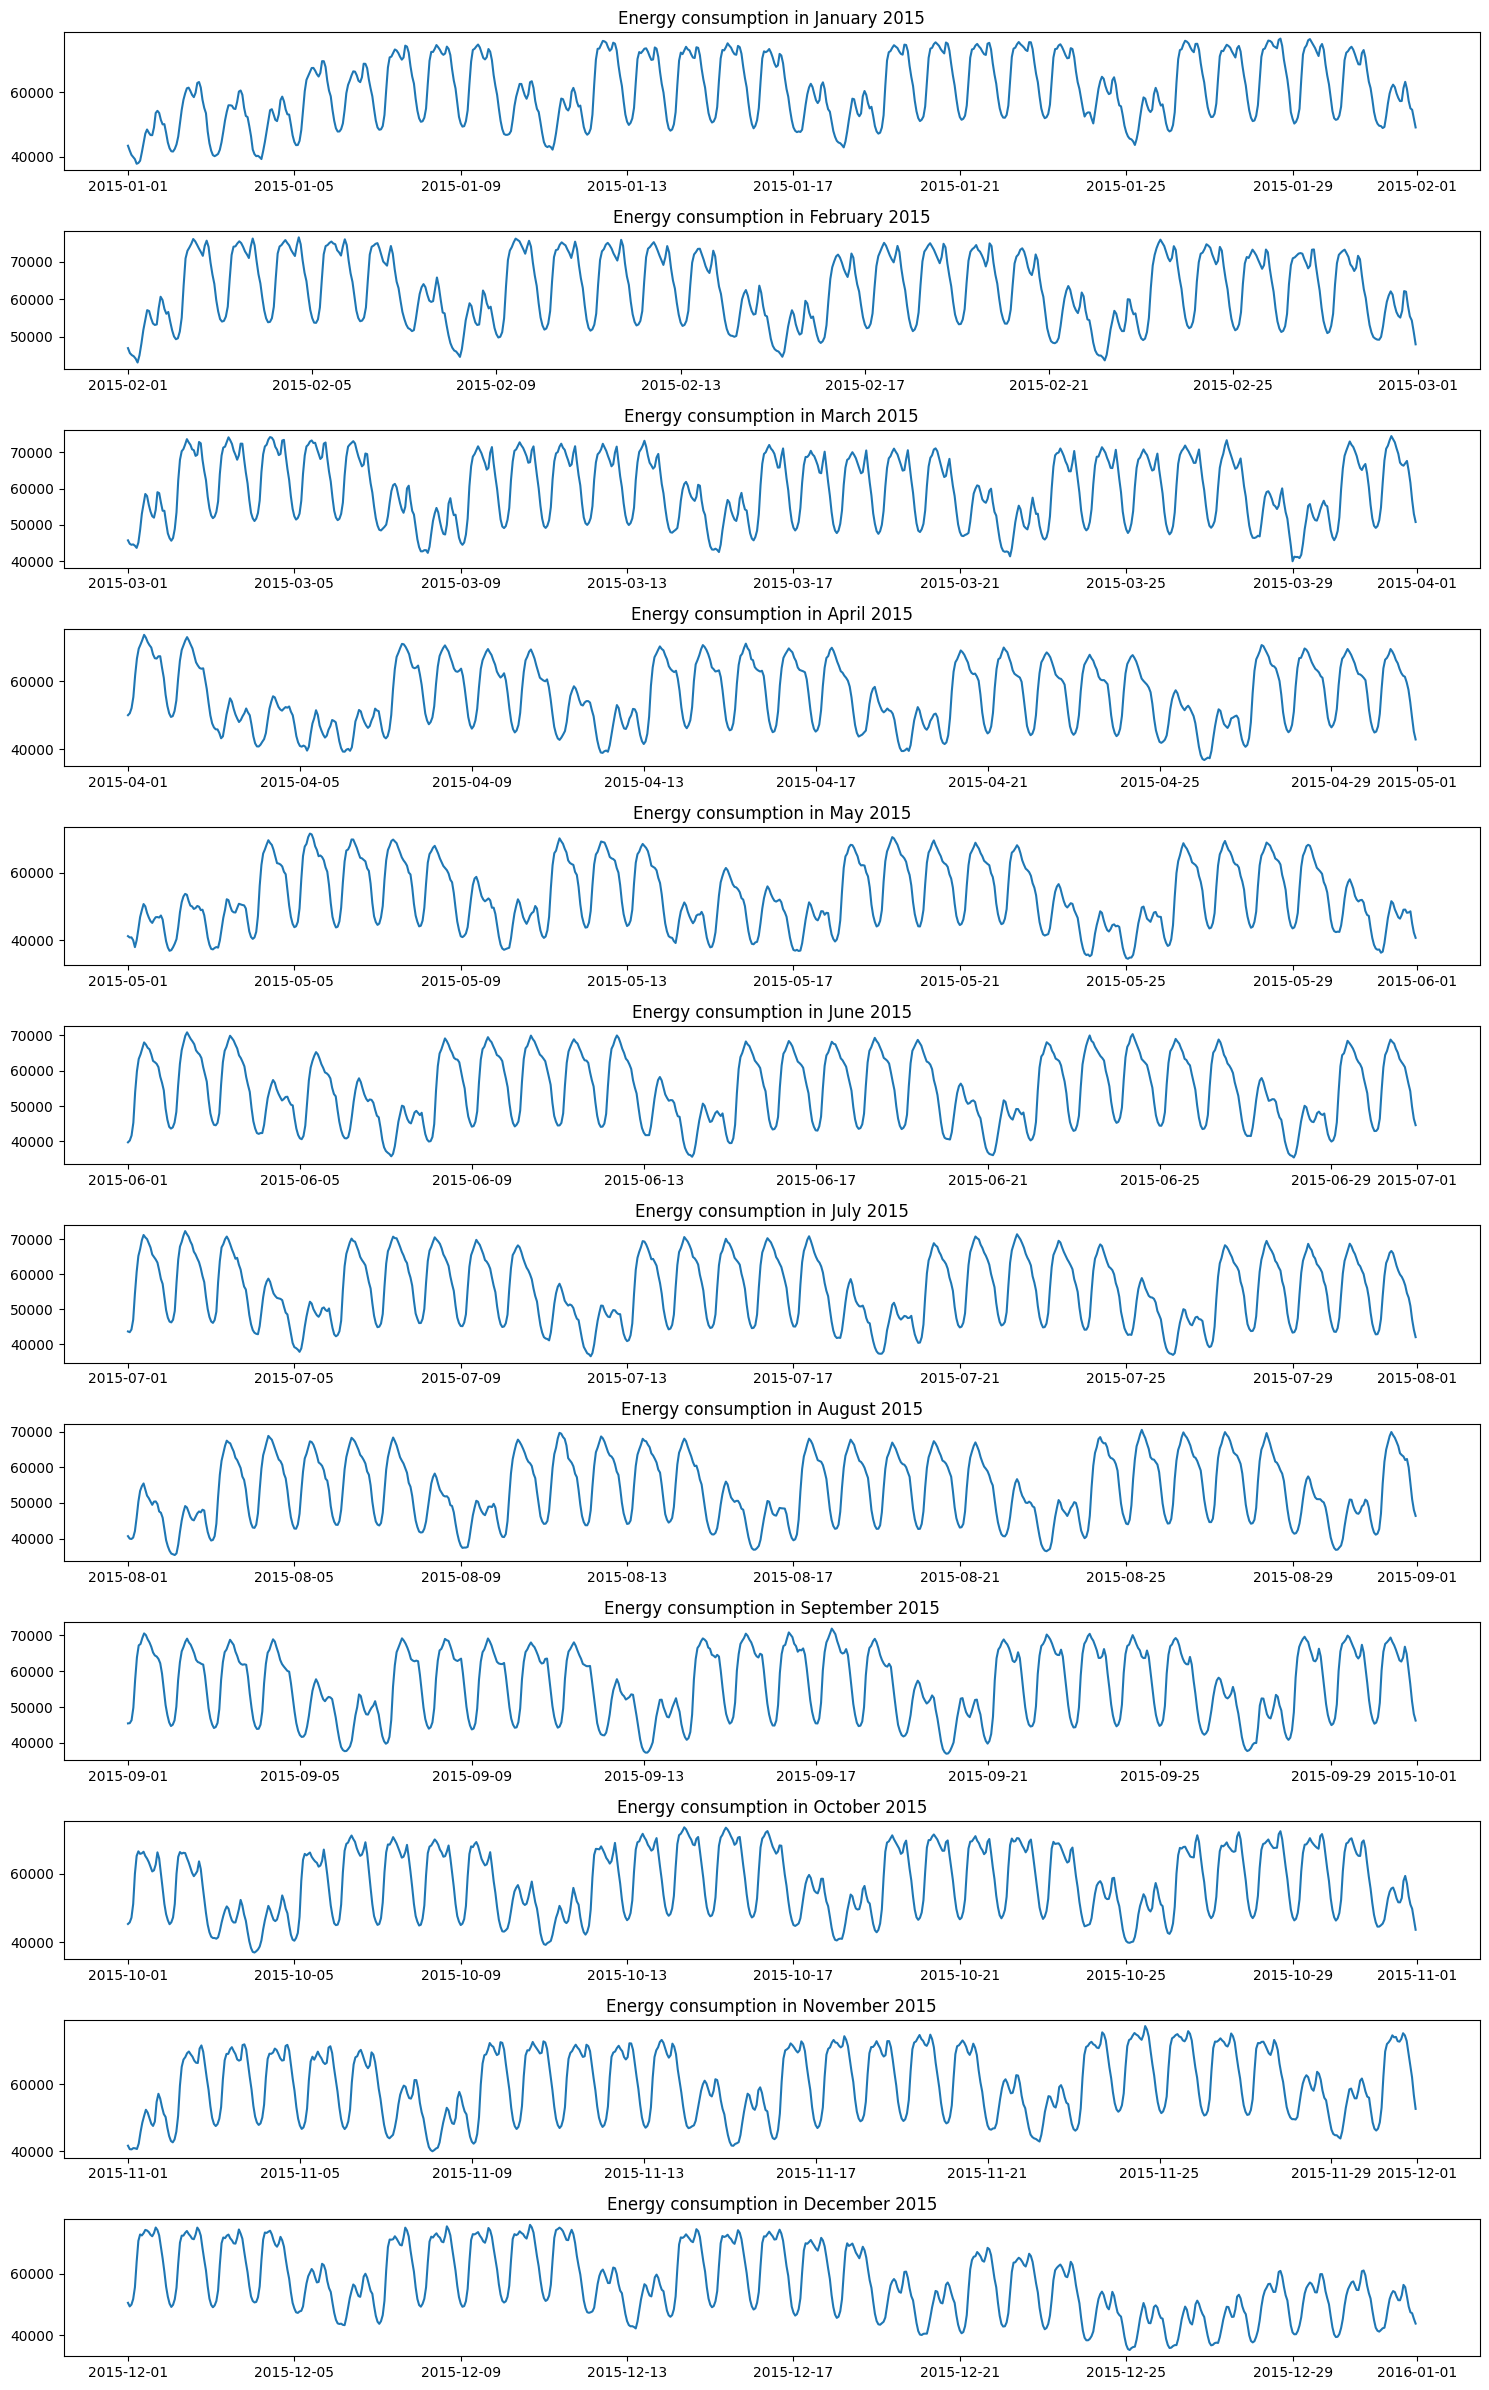

In [3]:
# for each month in year = 2015 ... plot the energy consumption

year = 2015
df_energy_2015 = df_energy[df_energy.index.year == year]

# create dict mapping month number to month name
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
              6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
              11: 'November', 12: 'December'}

# month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
#               6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',
#               11: 'Nov', 12: 'Dec'}

plt.figure(figsize=(15, 24))

for month_idx in range(1, 13):

    df_energy_2015_month = df_energy_2015[df_energy_2015.index.month == month_idx]

    # get month name from dict
    month_name = month_dict[month_idx]

    ax = plt.subplot(12, 1, month_idx)
    ax.plot(df_energy_2015_month.index, df_energy_2015_month['gesamt'])
    ax.set_title(f'Energy consumption in {month_name} {year}')

plt.tight_layout()
plt.show()

#### distribution - hist and box plots

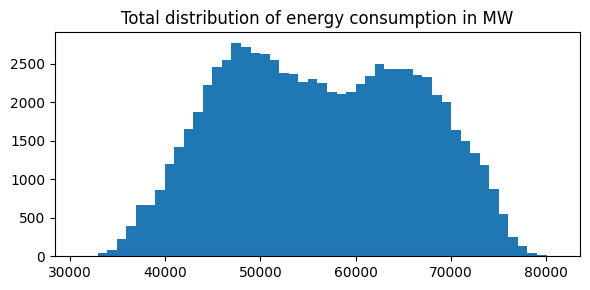

In [4]:
# plot distribution of "gesamt" column

plt.figure(figsize=(6, 3))

plt.hist(df_energy["gesamt"], bins=50)
plt.title("Total distribution of energy consumption in MW")

plt.tight_layout()
plt.show()

In [5]:
# print some descriptive stats of df_energy["gesamt"]
df_energy["gesamt"].describe()

count    78168.000000
mean     56366.804364
std      10002.910488
min      30909.000000
25%      48131.250000
50%      56064.875000
75%      64687.062500
max      81077.500000
Name: gesamt, dtype: float64

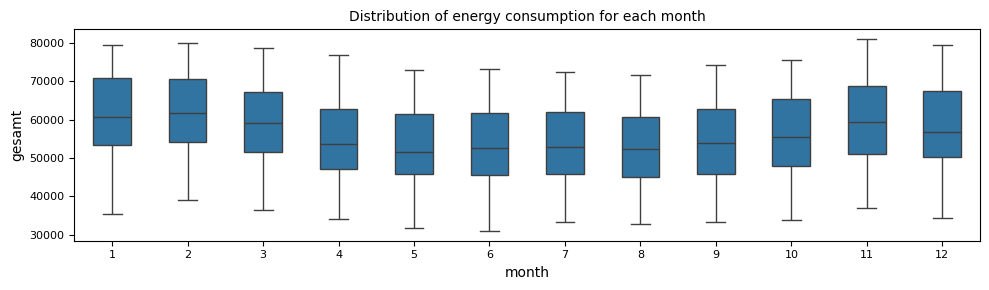

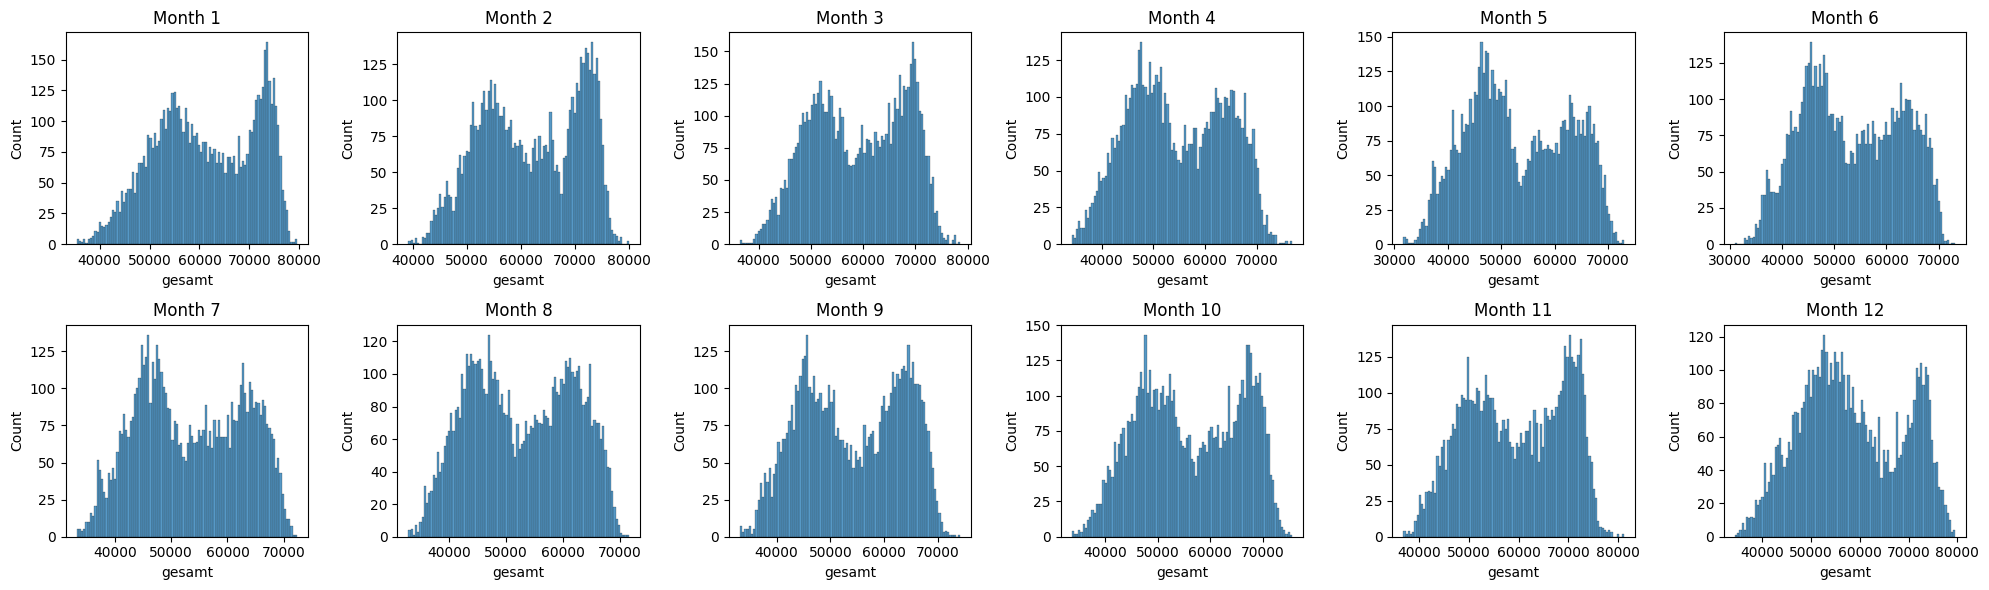

In [6]:
# plot distribution of "gesamt" column for each month

plt.figure(figsize=(10, 3))
# decrease box width
sns.boxplot(x=df_energy['timestamp_CET'].dt.month, y=df_energy['gesamt'], width=0.5)
plt.xlabel('month', fontsize=10)
plt.ylabel('gesamt', fontsize=10)
plt.title('Distribution of energy consumption for each month', fontsize=10)
# decrease all text size: title, axis labels, tick labels
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

# do it again in separate histogram plots

plt.figure(figsize=(20, 6))
for i, m_idx in enumerate(range(1,13)):
    plt.subplot(2, 6, i + 1)
    sns.histplot(df_energy[df_energy['timestamp_CET'].dt.month == m_idx]['gesamt'], bins=100)
    plt.title(f'Month {m_idx}')
plt.tight_layout()
plt.show()


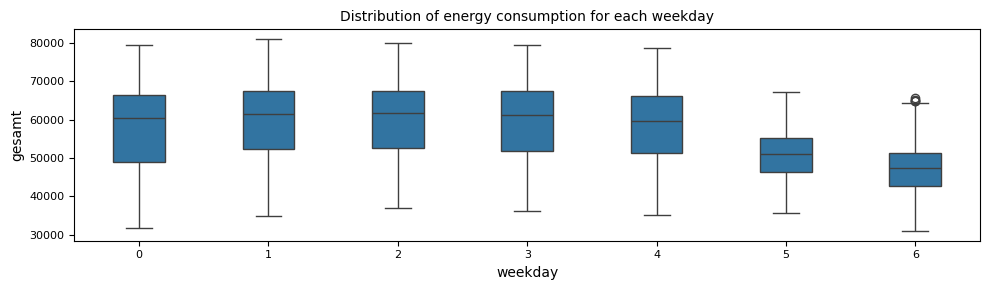

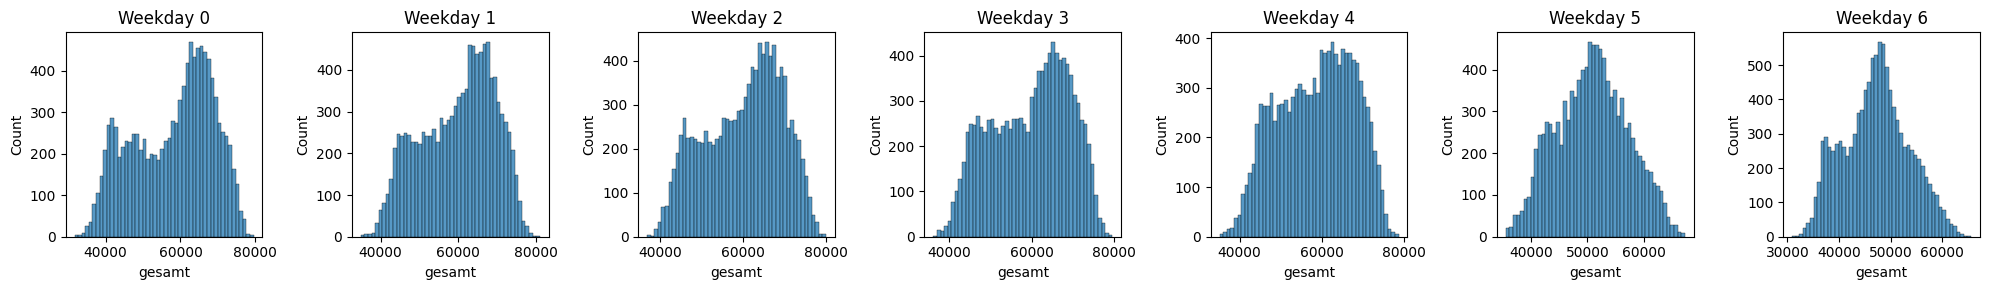

In [7]:
# plot distribution of "gesamt" column for each weekday

plt.figure(figsize=(10, 3))
sns.boxplot(x=df_energy['timestamp_CET'].dt.weekday, y=df_energy['gesamt'], width=0.4)
plt.xlabel('weekday', fontsize=10)
plt.ylabel('gesamt', fontsize=10)
plt.title('Distribution of energy consumption for each weekday', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

# do it again in separate histogram plots

plt.figure(figsize=(20, 3))
for i, day in enumerate(range(7)):
    plt.subplot(1, 7, i + 1)
    sns.histplot(df_energy[df_energy['timestamp_CET'].dt.weekday == day]['gesamt'], bins=50)
    plt.title(f'Weekday {day}')
plt.tight_layout()
plt.show()


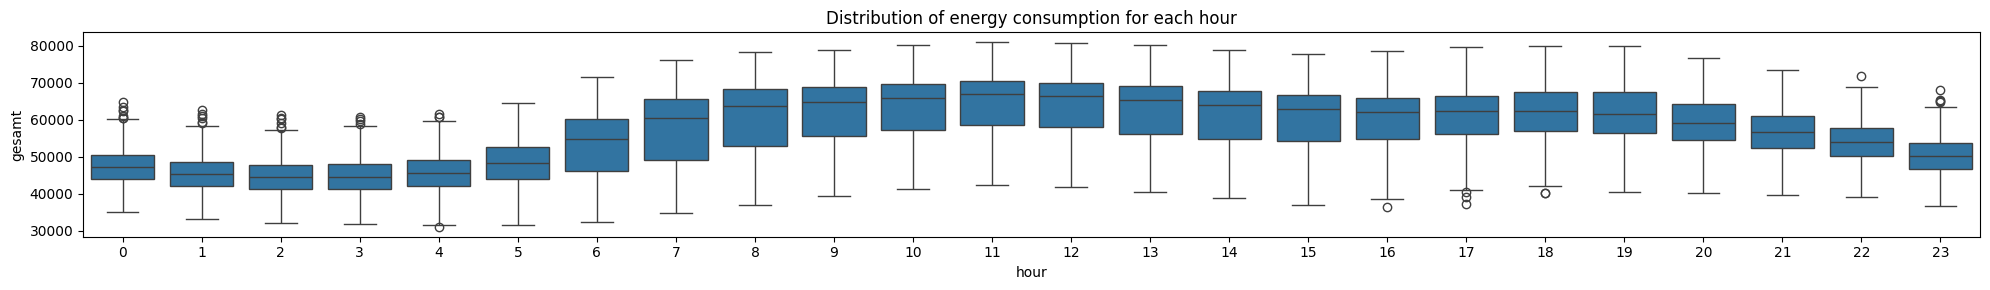

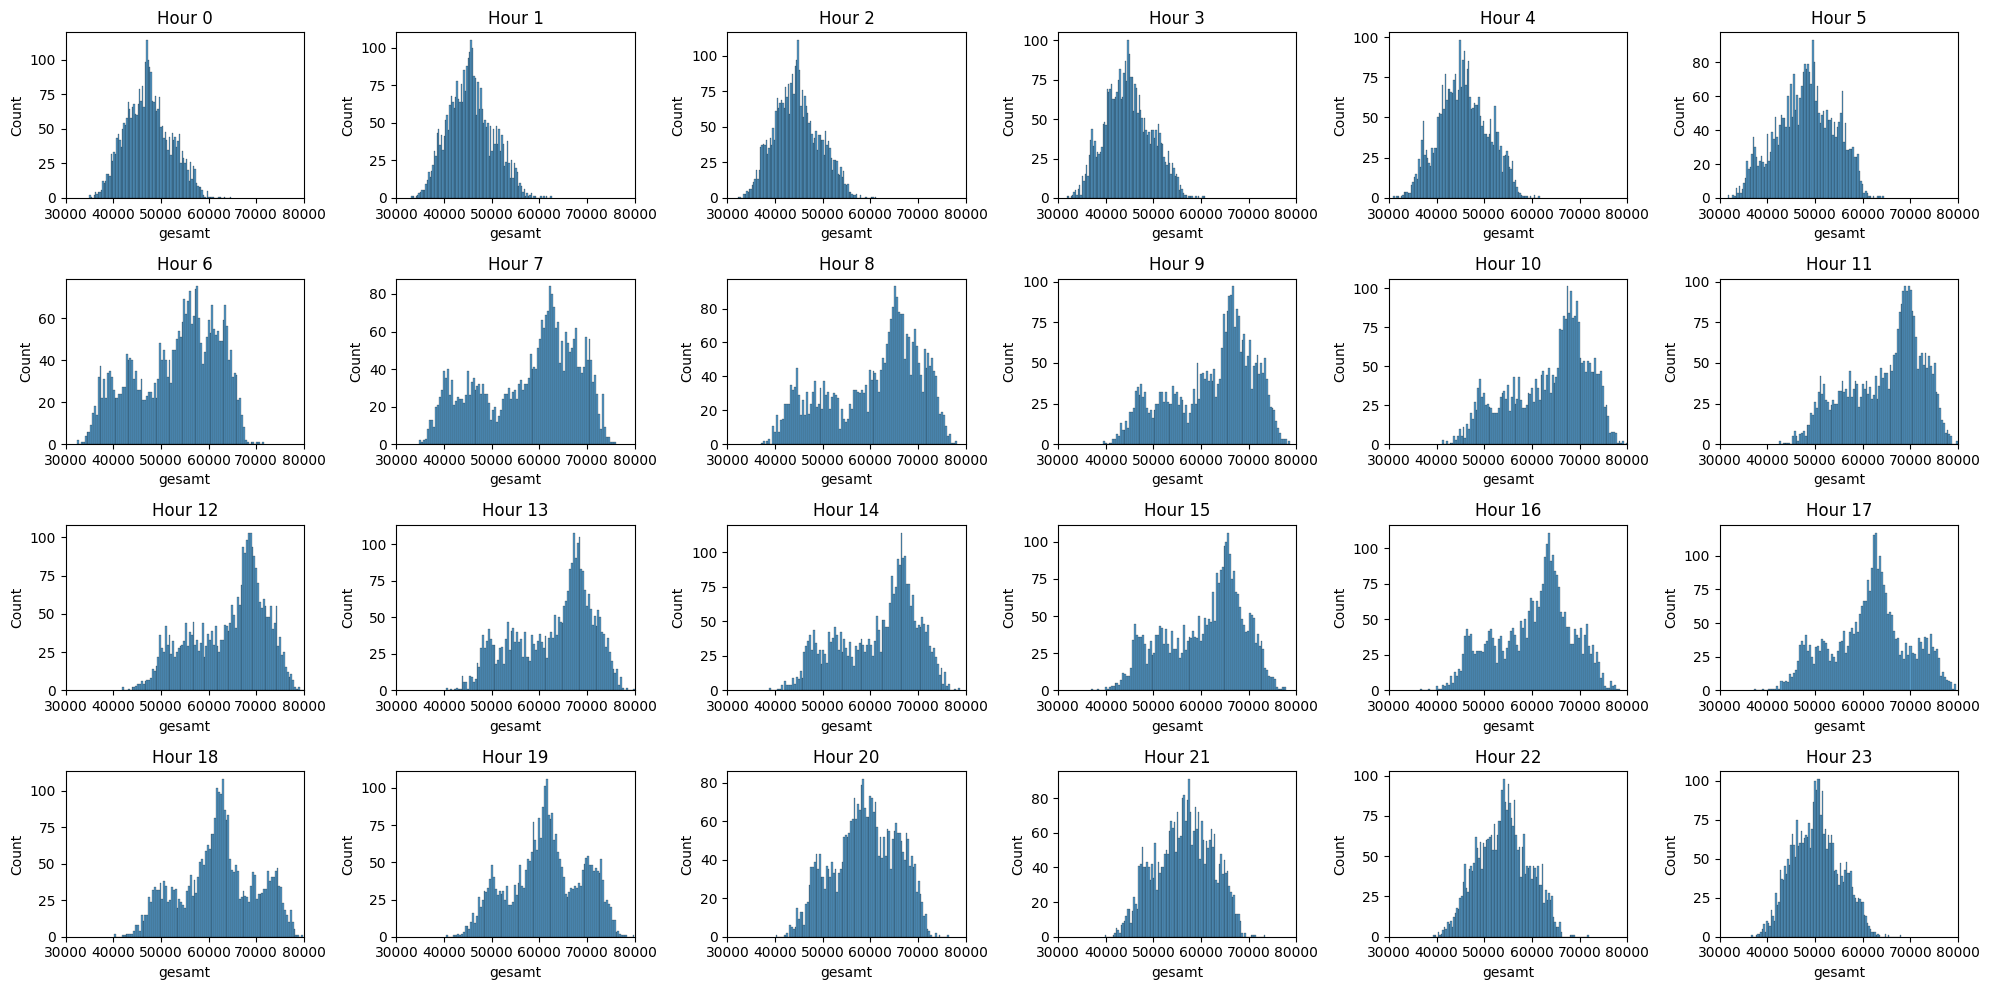

In [8]:
# plot distribution of "gesamt" column for each hour

plt.figure(figsize=(20, 3))
sns.boxplot(x=df_energy['timestamp_CET'].dt.hour, y=df_energy['gesamt'])
plt.xlabel('hour')
plt.ylabel('gesamt')
plt.title('Distribution of energy consumption for each hour')
plt.tight_layout()
plt.show()

# do it again in separate histogram plots

plt.figure(figsize=(20, 10))
for i, hr in enumerate(range(24)):
    plt.subplot(4, 6, i + 1)
    sns.histplot(df_energy[df_energy['timestamp_CET'].dt.hour == hr]['gesamt'], bins=100)
    # fix x axis from 30_000 to 80_000
    plt.xlim(30_000, 80_000)
    plt.title(f'Hour {hr}')
plt.tight_layout()
plt.show()


In [9]:
# # plot distribution of "gesamt" column for each hour and weekday

# weekday_mapping = {0: 'Monday', 
#                    1: 'Tuesday', 
#                    2: 'Wednesday', 
#                    3: 'Thursday', 
#                    4: 'Friday', 
#                    5: 'Saturday', 
#                    6: 'Sunday'}

# for day in range(7):

#     # turn integer weekday to name ie 0 to monday
#     weekday_name = weekday_mapping.get(day, 'Invalid Index')

#     df_day = df_energy[(df_energy['timestamp_CET'].dt.weekday == day)]
    
#     plt.figure(figsize=(20, 13))

#     # make this plot on top
#     ax1 = plt.subplot(5,6,(1,6))
#     sns.boxplot(x=df_day['timestamp_CET'].dt.hour, y=df_energy['gesamt'], ax=ax1)
#     ax1.set_xlabel('hour')
#     ax1.set_ylabel('gesamt')
#     ax1.set_ylim(30_000, 80_000)
#     ax1.set_title(f'{weekday_name} - hourly distribution of energy load')

#     # put this plot below
#     for i, hr in enumerate(range(24)):
#         ax2 = plt.subplot(5, 6, i + 7)
#         sns.histplot(df_day[df_day['timestamp_CET'].dt.hour == hr]['gesamt'], bins=50, ax=ax2)
#         # set axis x lims
#         ax2.set_xlim(30_000, 80_000)
#         ax2.set_ylim(0, 50)
#         # remove axis labels
#         ax2.set_xlabel('')
#         ax2.set_ylabel('')
#         ax2.set_title(f'hour {hr}')

#     plt.tight_layout()
#     plt.savefig(f'weekday_{day+1} hourly distribution hist plot.png')
#     # plt.show()
#     print(f'weekday_{day+1} done!')
#     plt.close()


In [10]:
# # plot distribution of "gesamt" column for each hour and weekday in summer & winter

# summer_months = [4, 5, 6, 7, 8, 9]
# winter_months = [10, 11, 12, 1, 2, 3] # heating starts in beginning of october

# for season in ['summer', 'winter']:

#     for day in range(7):

#         # turn integer weekday to name ie 0 to monday
#         weekday_name = weekday_mapping.get(day, 'Invalid Index')

#         if season == 'summer' :
#             df_day = df_energy[(df_energy['timestamp_CET'].dt.weekday == day) & 
#                                (df_energy['timestamp_CET'].dt.month.isin(summer_months))]
#         elif season == 'winter' :
#             df_day = df_energy[(df_energy['timestamp_CET'].dt.weekday == day) & 
#                                (df_energy['timestamp_CET'].dt.month.isin(winter_months))]

#         plt.figure(figsize=(20, 13))

#         # make this plot on top
#         ax1 = plt.subplot(5,6,(1,6))
#         sns.boxplot(x=df_day['timestamp_CET'].dt.hour, y=df_energy['gesamt'], ax=ax1)
#         ax1.set_xlabel('hour')
#         ax1.set_ylabel('gesamt')
#         ax1.set_ylim(30_000, 80_000)
#         ax1.set_title(f'{weekday_name} {season} - hourly distribution of energy load')

#         # put this plot below
#         for i, hr in enumerate(range(24)):
#             ax2 = plt.subplot(5, 6, i + 7)
#             sns.histplot(df_day[df_day['timestamp_CET'].dt.hour == hr]['gesamt'], bins=50, ax=ax2)
#             # set axis x lims
#             ax2.set_xlim(30_000, 80_000)
#             ax2.set_ylim(0, 25)
#             # remove labels
#             ax2.set_xlabel('')
#             ax2.set_ylabel('')
#             ax2.set_title(f'hour {hr}')

#         plt.tight_layout()
#         plt.savefig(f'weekday_{day+1} {season} hourly distribution hist plot.png')
#         # plt.show()

#         print(f'weekday_{day+1} done!')
#         plt.close()

### Add Dummy Vars

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [15]:
def create_dummy_df(df, hour_method='simple'):

    df_energy_dummy = df.copy()

    # binary dummy var for each month
    dummy_month = pd.get_dummies(df_energy['timestamp_CET'].dt.month, prefix='month').astype(int)
    # leave out first month to avoid multicollinearity
    dummy_month = dummy_month.iloc[:, 1:]

    # binary dummy var for each weekday
    dummy_weekday = pd.get_dummies(df_energy['timestamp_CET'].dt.weekday, prefix='weekday').astype(int)
    # leave out first weekday to avoid multicollinearity
    dummy_weekday = dummy_weekday.iloc[:, 1:]

    # # binary dummy var for each hour
    # dummy_hour = pd.get_dummies(df_energy['timestamp_CET'].dt.hour, prefix='hour').astype(int)
    # # leave out first hour to avoid multicollinearity
    # dummy_hour = dummy_hour.iloc[:, 1:]

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # separate hourly dummy vars for summer and winter months

    # summer_months = [4, 5, 6, 7, 8, 9]
    # df_energy_dummy['is_summer'] = df_energy['timestamp_CET'].dt.month.isin(summer_months).astype(int)

    # # create dummy variables for each hour in summer months
    # for hr in range(1, 24):
    #     # skip hour 0 in summer to avoid multicollinearity
    #     df_energy_dummy[f'hour_{hr}_summer'] = ((df_energy_dummy['is_summer'] == 1) & (df_energy_dummy['timestamp_CET'].dt.hour == hr)).astype(int)

    # for hr in range(1, 24):
    #     # skip hour 0 in winter to avoid multicollinearity
    #     df_energy_dummy[f'hour_{hr}_winter'] = ((df_energy_dummy['is_summer'] == 0) & (df_energy_dummy['timestamp_CET'].dt.hour == hr)).astype(int)

    # # drop is_summer
    # df_energy_dummy.drop(columns=['is_summer'], inplace=True)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # separate hourly dummy vars for EVERY month

    month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May',
                6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October',
                11: 'November', 12: 'December'}

    for m_idx in range(1, 13):
        
        m_name = month_dict[m_idx][:3].lower() # short version of month name

        for hr in range(1, 24):
            # skip hour 0 to avoid multicollinearity
            df_energy_dummy[f'hour_{hr}_{m_name}'] = ((df_energy_dummy['timestamp_CET'].dt.month == m_idx) & 
                                                    (df_energy_dummy['timestamp_CET'].dt.hour == hr)).astype(int)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # these are obsolete since effects already captured in hour and weekday dummies

    # binary dummy var for weekend
    # dummy_weekend = df_energy['timestamp_CET'].dt.weekday.isin([5,6]).rename('is_weekend').astype(int)
    # binary dummy var for night
    # dummy_night = df_energy['timestamp_CET'].dt.hour.isin([22,23,0,1,2,3]).rename('is_night').astype(int)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # concat all dummies
    # df_energy_dummy = pd.concat([df_energy_dummy, dummy_season], axis=1)
    df_energy_dummy = pd.concat([df_energy_dummy, dummy_month], axis=1)
    df_energy_dummy = pd.concat([df_energy_dummy, dummy_weekday], axis=1)
    # df_energy_dummy = pd.concat([df_energy_dummy, dummy_hour], axis=1)

    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
    # create holiday dummies

    # get all years in dataframe
    uniq_yrs = df_energy['timestamp_CET'].dt.year.unique()
    # print(uniq_yrs)

    # get holidays for germany
    # holidays_de = holidays.DE(years=uniq_yrs)

    # get holidays for germany for all states and combine them into one single dict
    states = ['BB', 'BE', 'BW', 'BY', 'BYP', 'HB', 'HE', 'HH', 'MV', 'NI', 'NW', 'RP', 'SH', 'SL', 'SN', 'ST', 'TH']
    holidays_de = holidays.CountryHoliday('DE', years=uniq_yrs)
    for state in states:
        holidays_de.update(holidays.CountryHoliday('DE', state=state, years=uniq_yrs))
    # sort holidays
    holidays_de = dict(sorted(holidays_de.items()))
    # print(holidays_de)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    # newyears + silvester ist kein feiertag aber die meisten nehmen trotzdem frei
    # create dummy variable for all rows where timestamp_CET is 12.31 or 01.01
    df_energy_dummy['is_holiday_newyear_d31'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 31))
    df_energy_dummy['is_holiday_newyear_d01'] = ((df_energy_dummy['timestamp_CET'].dt.month == 1) & (df_energy_dummy['timestamp_CET'].dt.day == 1))

    # Heilige Drei Könige (01.06)
    threekings_dates = [k for k, v in holidays_de.items() if v == 'Heilige Drei Könige']
    df_energy_dummy['is_holiday_threekings'] = df_energy_dummy['timestamp_CET'].dt.date.isin(threekings_dates)

    # Frauentag (03.08)
    # df_energy_dummy['is_holiday_womensday'] = ((df_energy_dummy['timestamp_CET'].dt.month == 3) & (df_energy_dummy['timestamp_CET'].dt.day == 8))

    # Karfreitag (easter - 2d)
    karfreitag_dates = [k for k, v in holidays_de.items() if v == 'Karfreitag']
    df_energy_dummy['is_holiday_karfreitag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(karfreitag_dates)

    # Eastermonday (easter + 1d)
    easter_dates = [k for k, v in holidays_de.items() if v == 'Ostermontag']
    df_energy_dummy['is_holiday_easter'] = df_energy_dummy['timestamp_CET'].dt.date.isin(easter_dates)

    # Erster Mai / Tag der Arbeit (05.01)
    erstermai_dates = [k for k, v in holidays_de.items() if v == 'Erster Mai']
    df_energy_dummy['is_holiday_erstermai'] = df_energy_dummy['timestamp_CET'].dt.date.isin(erstermai_dates)

    # Christi Himmelfahrt (easter + 39d)
    himmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Christi Himmelfahrt']
    df_energy_dummy['is_holiday_himmelfahrt'] = df_energy_dummy['timestamp_CET'].dt.date.isin(himmelfahrt_dates)

    # Pfingstmontag (easter + 50d)
    pfingstmontag_dates = [k for k, v in holidays_de.items() if v == 'Pfingstmontag']
    df_energy_dummy['is_holiday_pfingstmontag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(pfingstmontag_dates)

    # Fronleichnam (easter + 60d)
    fronleichnam_dates = [k for k, v in holidays_de.items() if v == 'Fronleichnam']
    df_energy_dummy['is_holiday_fronleichnam'] = df_energy_dummy['timestamp_CET'].dt.date.isin(fronleichnam_dates)

    # Maria Himmelfahrt (08.15)
    mariahimmelfahrt_dates = [k for k, v in holidays_de.items() if v == 'Mariä Himmelfahrt']
    df_energy_dummy['is_holiday_mariahimmelfahrt'] = df_energy_dummy['timestamp_CET'].dt.date.isin(mariahimmelfahrt_dates)

    # Tag der Deutschen Einheit (10.03)
    einheit_dates = [k for k, v in holidays_de.items() if v == 'Tag der Deutschen Einheit']
    df_energy_dummy['is_holiday_einheit'] = df_energy_dummy['timestamp_CET'].dt.date.isin(einheit_dates)

    # Reformationstag (10.31)
    reformationstag_dates = [k for k, v in holidays_de.items() if v == 'Reformationstag']
    df_energy_dummy['is_holiday_reformationstag'] = df_energy_dummy['timestamp_CET'].dt.date.isin(reformationstag_dates)

    # Allerheiligen (11.01)
    allerheiligen_dates = [k for k, v in holidays_de.items() if v == 'Allerheiligen']
    df_energy_dummy['is_holiday_allerheiligen'] = df_energy_dummy['timestamp_CET'].dt.date.isin(allerheiligen_dates)

    # christmas = list of datetimes from 12.24 to 12.26 
    df_energy_dummy['is_holiday_xmas_d23'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 23))
    df_energy_dummy['is_holiday_xmas_d24'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 24))
    df_energy_dummy['is_holiday_xmas_d25'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 25))
    df_energy_dummy['is_holiday_xmas_d26'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 26))

    # brückentage zwischen weihnachten und neujahr
    # 12.27, 12.28, 12.29, 12.30
    df_energy_dummy['is_holiday_xmas2newyear'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day.isin([27,28,29,30])))
    # df_energy_dummy['is_holiday_xmas2newyear_d27'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 27))
    # df_energy_dummy['is_holiday_xmas2newyear_d28'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 28))
    # df_energy_dummy['is_holiday_xmas2newyear_d29'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 29))
    # df_energy_dummy['is_holiday_xmas2newyear_d30'] = ((df_energy_dummy['timestamp_CET'].dt.month == 12) & (df_energy_dummy['timestamp_CET'].dt.day == 30))

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # reformat all columns that begin with "is_holiday" to int
    for col in df_energy_dummy.columns:
        if col.startswith('is_holiday'):
            df_energy_dummy[col] = df_energy_dummy[col].astype(int)

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # only one holiday dummy for all holidays

    # check if date is holiday
    # df_energy_dummy['is_holiday'] = df_energy_dummy['timestamp_CET'].dt.date.isin(holiday_dates_de).astype(int)

    # df_energy_dummy.tail(5)

    return df_energy_dummy

,timestamp_CET,gesamt,hour_1_jan,hour_2_jan,hour_3_jan,hour_4_jan,hour_5_jan,hour_6_jan,hour_7_jan,hour_8_jan,...,is_holiday_fronleichnam,is_holiday_mariahimmelfahrt,is_holiday_reformationstag,is_holiday_allerheiligen,is_holiday_einheit,is_holiday_xmas_d23,is_holiday_xmas_d24,is_holiday_xmas_d25,is_holiday_xmas_d26,is_holiday_xmas2newyear
timestamp_UTC,,,,,,,,,,,,,,,,,,,,,
2023-12-01 18:00:00+00:00,2023-12-01 19:00:00+01:00,65481.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 19:00:00+00:00,2023-12-01 20:00:00+01:00,61924.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 20:00:00+00:00,2023-12-01 21:00:00+01:00,58844.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 21:00:00+00:00,2023-12-01 22:00:00+01:00,56488.50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-01 22:00:00+00:00,2023-12-01 23:00:00+01:00,53533.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# # check correlation between variables in df to avoid multicollinearity
# # print(df_energy_dummy.dtypes)

# # in a plot and highlight high correlations
# fig = plt.figure(figsize=(20, 20))
# plt.matshow(df_energy_dummy.corr(), fignum=fig.number)

# # add colorbar
# plt.colorbar()

# # add labels, rotate label text
# plt.xticks(range(df_energy_dummy.shape[1]), df_energy_dummy.columns, rotation=90)
# plt.yticks(range(df_energy_dummy.shape[1]), df_energy_dummy.columns)
# # make label text small
# plt.tick_params(labelsize=5)

# plt.show()

### Fit Linear Model

In [18]:
def fit_lin_reg(df, method='ols', test_perc=0.01, drop_cols=None):

    if drop_cols is None:
        drop_cols = ['timestamp_CET']
    else:
        drop_cols.append('timestamp_CET')

    # drop columns
    df = df.drop(drop_cols, axis=1)

    # do train test split manually
    n_total = df.shape[0]
    n_train = int((1-test_perc) * n_total)
    n_test = n_total - n_train

    X_train = df.iloc[:n_train]
    X_test = df.iloc[-n_test:]

    y_train = X_train['gesamt']
    y_test = X_test['gesamt']

    X_train = X_train.drop(['gesamt'], axis=1)
    X_test = X_test.drop(['gesamt'], axis=1)

    # Add a constant term to the features matrix for statsmodels
    X_train = sm.add_constant(X_train)
    # Create model using OLS (Ordinary Least Squares)
    model = sm.OLS(y_train, X_train)

    if method == 'ols' :

        results = model.fit()
        print(results.summary())

    elif method == 'ridge' :

        results = model.fit_regularized(method = 'elastic_net')
        print(results.params.to_string())
        # [TODO] how to get r squared ???

    # Add a constant term to the features matrix for the test set
    X_test = sm.add_constant(X_test, has_constant='add')

    # PROBLEM eg if first column is "is_summer" and the test set is in summer, then the first column is already constant = 1 everywhere
    # BUT we still want to add a constant row to make sure the model works / has the right dimension
    # SO we set has_constant = 'add' to force the constant row to be added

    # Make predictions
    y_pred = results.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse}")

    # Plot out of sample predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='test')
    plt.plot(y_test.index, y_pred, label='predicted')
    plt.title(f"Lin Reg using {method} and {len(X_train.columns)} predictors - RMSE: {rmse:.2f}")
    plt.legend()
    plt.show()

    return X_train, X_test, y_train, y_test, results, y_pred


                            OLS Regression Results                            
Dep. Variable:                 gesamt   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     853.5
Date:                Fri, 22 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:19:25   Log-Likelihood:            -2.7842e+05
No. Observations:               29328   AIC:                         5.575e+05
Df Residuals:                   29016   BIC:                         5.600e+05
Df Model:                         311                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

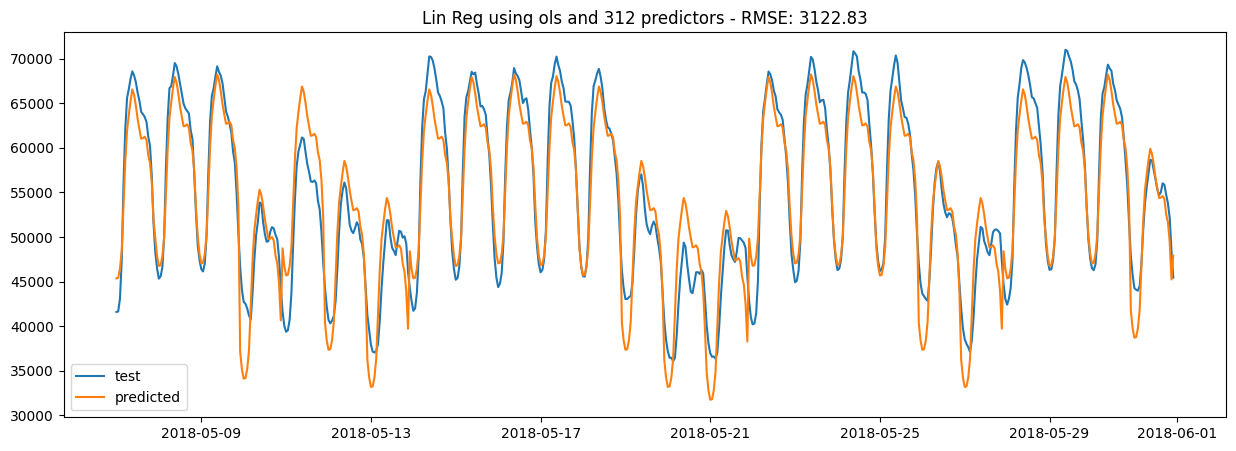

In [19]:
# take smaller dataset
df_energy_dummy_small = df_energy_dummy.loc[(df_energy_dummy['timestamp_CET'] > '2015-01-01') & 
                                            (df_energy_dummy['timestamp_CET'] <= '2018-06-01')]
                                            
# fit model on all data and another fit without "is_weekend" and "is_night"
res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method='ols')
# res = fit_lin_reg(df_energy_dummy_small, test_perc=0.02, method=fit_method)


In [298]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df_energy_dummy_small is your DataFrame
# Replace 'your_target_column' with the actual name of your target column
target_column = 'gesamt'

# Select features and target variable
features = df_energy_dummy_small.drop([target_column, 'timestamp_CET'], axis=1)
target = df_energy_dummy_small[target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.01, random_state=42)

# Fit Kernel Regression
kr = KernelReg(y_train, X_train, var_type='c' * X_train.shape[1])
y_pred, _ = kr.fit()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

# Plot predictions vs. actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()


In [7]:
# take last n values only
n_last = 24*365
df_energy_small = df_energy.iloc[-n_last:][['gesamt']]

# take values from 2020-01-01 to 2023-01-01
# df_energy_small = df_energy.loc['2020-01-01':'2023-01-01'][['gesamt']]
df_energy_small.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2020-12-20 14:00:00+00:00 to 2023-12-20 13:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gesamt  26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB


### MSTL

In [ ]:

mstl = MSTL(df_energy_small, periods=[24, 24*7], iterate=1, 
            stl_kwargs={"seasonal_deg": 0,
                        "inner_iter": 2,
                        "outer_iter": 0})

res = mstl.fit()

plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=10)

res.plot()
plt.tight_layout()
plt.show()

### TBATS

In [11]:
from tbats import TBATS
# use original tbtas library as sktime adapter has problems with returning fitted params ...

# take last n values only
n_last = int(24*365 / 4)
df_energy_small = df_energy.iloc[-n_last:][['gesamt']]

# = = = = = = = = = = = = = 
# Train Test Split

y = df_energy_small['gesamt']
test_perc = 0.1
test_size = np.floor(len(y)*test_perc).astype(int)
y_train, y_test = temporal_train_test_split(y, test_size=test_size)

# = = = = = = = = = = = = = 
# TBATS Forecasting Model

forecaster = TBATS(
    use_box_cox=False,
    use_trend=True,
    use_damped_trend=True,
    seasonal_periods=[24],
    use_arma_errors=False,
    n_jobs=1)

print('start fitting ...')
fitted_model = forecaster.fit(y_train)
print(fitted_model.summary())

start fitting ...
Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [24.]
Seasonal harmonics [10]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.450052
Trend (Beta): 0.136602
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-2.56441101e-07 -4.71684126e-07]
AR coefficients []
MA coefficients []
Seed vector [ 5.01811678e+04 -5.39300868e+02  3.87624333e+03  2.99641178e+03
  6.11027985e+02 -6.88076010e+02 -1.66035098e+02 -2.07825438e+01
 -4.93380963e+01  4.44871118e+01  1.46901776e+01 -1.55386761e+01
  8.15955290e+03 -1.87299300e+03  2.49426370e+02 -1.16693516e+02
 -1.68525518e+02  2.20896565e+02  2.79184130e+01 -4.59239498e+01
 -2.19272653e+01  2.03855332e+01]

AIC 42162.014417


In [ ]:
y_pred, confidence_info = fitted_model.forecast(steps=test_size, confidence_level=0.95)

In [44]:
# fitted_model.plot()
# [TODO] look for same functionality as in tbats fnct in R forecast package to plot decomposition
# doesnt seem to have a plot function ...
# GOAL = want to verify ... is MSTL the same as TBATS given the same parameters ???

In [40]:
# Time series analysis
# print(fitted_model.y_hat) # in sample prediction
# print(fitted_model.resid) # in sample residuals
# print(fitted_model.aic)

# Reading model parameters
# print(fitted_model.params.alpha)
# print(fitted_model.params.beta)
# print(fitted_model.params.x0)
# print(fitted_model.params.components.use_box_cox)
# print(fitted_model.params.components.seasonal_harmonics)

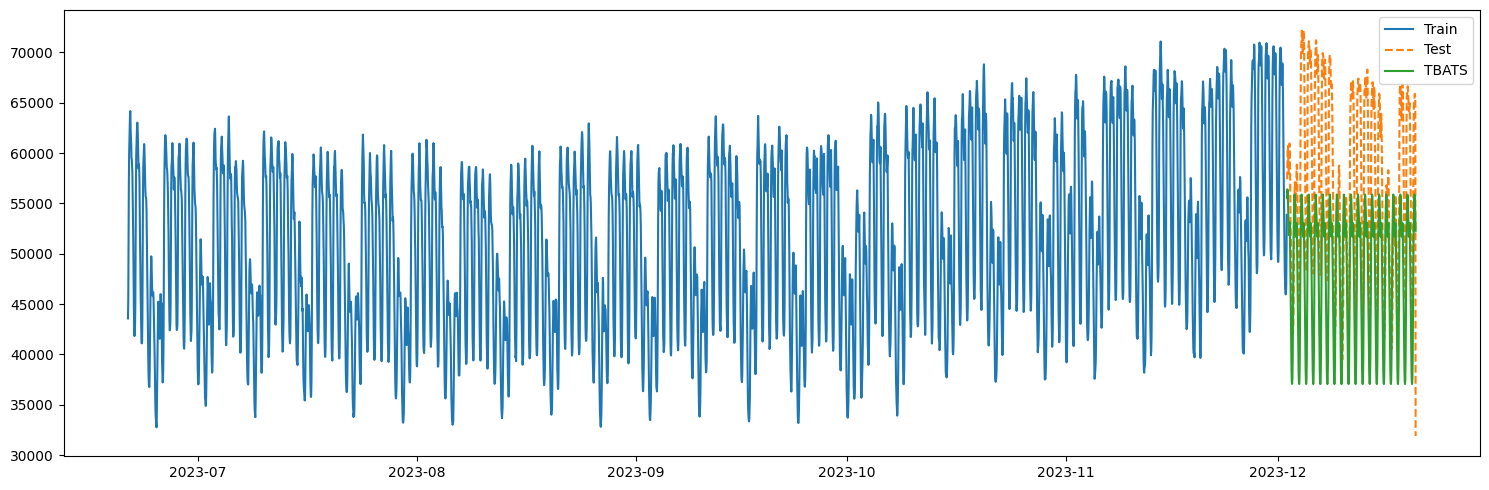

In [10]:
plt.figure(figsize=(15, 5))

plt.plot(y_train, label='Train')
plt.plot(y_test, ls='--', label='Test')
plt.plot(y_test.index, y_pred, label='TBATS')

# shift index back by 1 year
# last_yr_idx = df_energy_small.index - pd.DateOffset(years=1)
# plt.plot(df_energy[last_yr_idx].values, label='Last Year')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# get national holidays in germany
# make dummy variables in dataframe for each holiday
# regress on dummy variables and seasonal components as described in De Livera, Hyndman, Snyder paper
# obtain estimated effect of holidays which we can now remove from the series
# do one more MSTL on the series without holiday effects

In [ ]:
import holidays
bw_holidays = holidays.DE(prov='BW')

### FCAST based on Thursday 00:00

In [8]:
# get date of next thursday 00:00 based on todays date
today = datetime.today()
next_thursday = today + pd.DateOffset(days=(3-today.weekday())%7)
next_thursday = next_thursday.replace(hour=0, minute=0, second=0, microsecond=0)
print(next_thursday)

# get fcast index
# fcast index = starting from thursday 00:00 of the week until 36, 40, 44 and 60, 64, 68 hours ahead
fcast_idx = next_thursday + pd.to_timedelta([36, 40, 44, 60, 64, 68], unit='h')
fcast_idx

2023-12-21 00:00:00


DatetimeIndex(['2023-12-22 12:00:00', '2023-12-22 16:00:00',
               '2023-12-22 20:00:00', '2023-12-23 12:00:00',
               '2023-12-23 16:00:00', '2023-12-23 20:00:00'],
              dtype='datetime64[ns]', freq=None)

'2023-12-20'